In [1]:
import numpy as np
import casadi as ca
from utils import *


In [2]:
# Step1: define uneven terrain environment

# Define the profile of terrain h(p)
def h(p, case):

    if case == 1:  # zero slope
        h = 0

    elif case == 2: # constant slope
        h = (ca.pi * p) / 18

    elif case == 3: # varying slope
        h = (ca.pi / 18) * ca.sin(p)

    elif case == 4: # varying slope for underactuated case
        h = (ca.pi / 18) * ca.cos(p)

    return h


In [3]:
# Calculate inclination angle theta(p) based on terrain profile h(p)
# Hint: 1) use symbolic function h_func as input;
#       2) theta defined in radius;

def symbolic_theta(h_func):

    p = ca.SX.sym("p")

    h = h_func(p) 
    dh_dp = ca.jacobian(h, p)
    theta = ca.atan(dh_dp)
    
    return ca.Function("theta", [p], [theta])

# Notice: with function h(p), we can also use numerical differentiation to calculate dh/dp


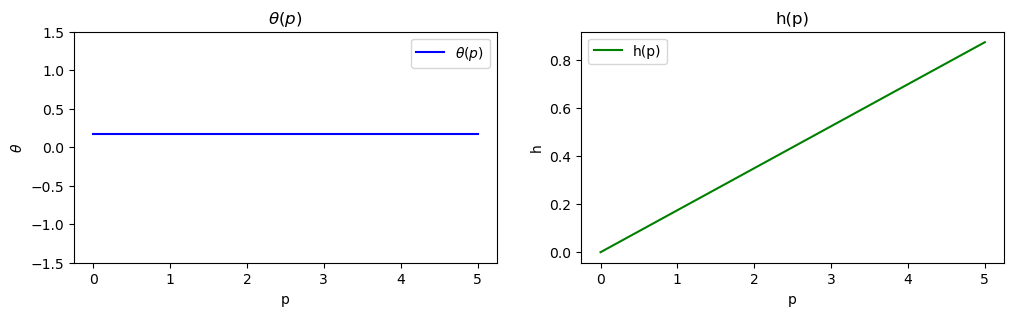

In [4]:
# Define the initial / target state
case = 2 # 1, 2, 3, 4
initial_position = 0
target_position = 3

# Instantiate class 'Env'
env = Env(case, initial_position, target_position, h, symbolic_theta)

# Results visualisation: to display theta curve (left side) and shape of terrain (right side) 
p_vals = np.linspace(0, 5, 50) # generate grid mesh on p
env.test_env(p_vals)

In [5]:
# Step2: define dynamics of 1d car
# Hint: use symbolic function theta_func as input;

def symbolic_dynamics(theta_func):

    p = ca.SX.sym("p")
    v = ca.SX.sym("v")
    a = ca.SX.sym("a")

    # call function theta from environment
    theta = theta_func(p)

    # expression of dynamics
    dpdt = v
    dvdt = a * ca.cos(theta)
    
    lhs = ca.vertcat(dpdt, dvdt)

    return ca.Function("dynamics", [ca.vertcat(p, v), ca.vertcat(a)], [lhs])

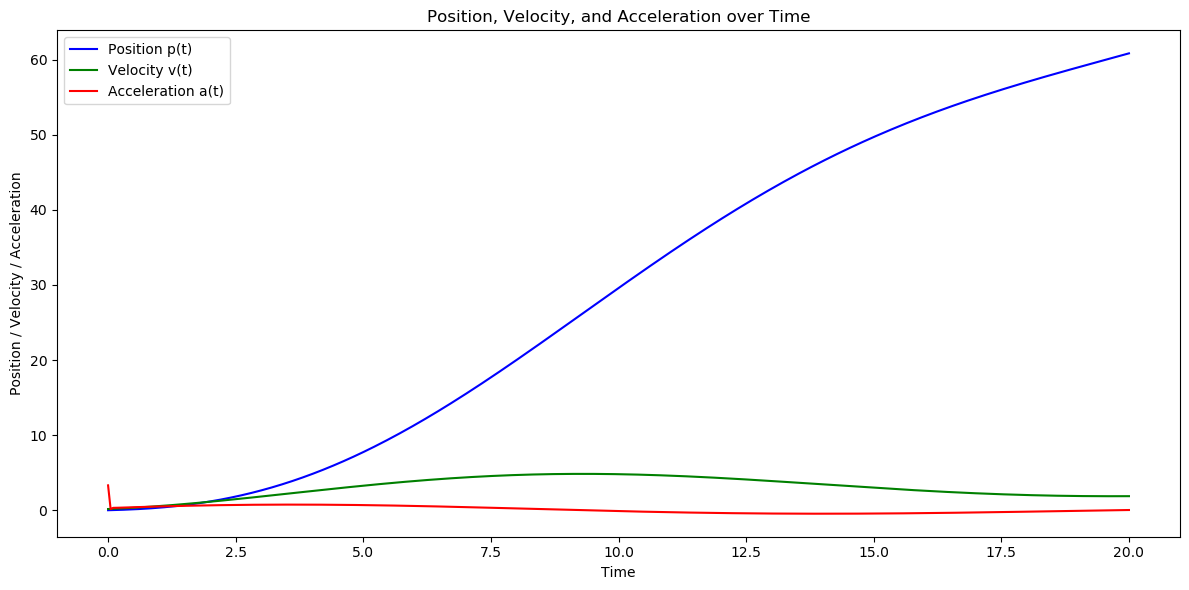

In [6]:
# Define the states and input as symbolic variables
state_names = ["p", "v"]
input_names = ["a"]

# Instantiate class 'Dynamics'
# Hint: symbolic_dynamics depends on the methode from external object (theta), therefor external object 'env' must entry the constructor;
dynamics = Dynamics(state_names, input_names, symbolic_dynamics, env)

# Results visualisation: 
#   simulation under constant acc case, plot p / v / a curve for all profiles

# Instantiate a template PID controller class
controller = PIDController(target_position=env.target_position)

# Instantiate the simulator, run the simulation, and plot the results
simulator = Simulator(dynamics, controller, env)
simulator.run_simulation()
simulator.display_final_results()
#simulator.display_animation()



In [ ]:
# Step3: implementation of one loop in DPA

def DPA():
    pass

    # tbd: grid world (min) or continue problem (optimizor)?


In [8]:
# Step4: run DPA loop from backwards, get the optimal policy sequance


In [9]:
# Results visualisation: 